In [ ]:
!pip install av

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
from torch import nn
from torch import optim
import os
import numpy as np
import pandas as pd
from torchvision.io import read_video
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
import torch.nn.functional as F
from torchsummary import summary
from torch import optim

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import time
import copy

In [ ]:
# define transformation
#transformation = transforms.Compose([
#                    transforms.ToTensor(),
#                    transforms.Resize(64)
#])
#이 방법쓰면 바로
preprocess_new_ver = transforms.Compose(
    [transforms.ToPILImage(),
    transforms.Resize((244,244)),
    #transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# DenseNet BottleNeck
class BottleNeck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        inner_channels = 4 * growth_rate

        self.residual = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, inner_channels, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(inner_channels),
            nn.ReLU(),
            nn.Conv2d(inner_channels, growth_rate, 3, stride=1, padding=1, bias=False)
        )

        self.shortcut = nn.Sequential()

    def forward(self, x):
        return torch.cat([self.shortcut(x), self.residual(x)], 1)


# Transition Block: reduce feature map size and number of channels
class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.down_sample = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, 1, stride=1, padding=0, bias=False),
            nn.AvgPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.down_sample(x)

# DenseNet
#DenseNet([6, 12, 24, 6])
#여기선 num_classes에 프레임 수가 들어가야 된다(모델 구조상)
class DenseNet(nn.Module):
    def __init__(self, nblocks, growth_rate=12, reduction=0.5, num_classes=2, init_weights=True):
        super().__init__()
        self.growth_rate = growth_rate
        inner_channels = 2 * growth_rate # output channels of conv1 before entering Dense Block
        self.transfer_inner_channels = inner_channels

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, inner_channels, 7, stride=2, padding=3),
            nn.MaxPool2d(3, 2, padding=1)
        )

        self.features = nn.Sequential()

        for i in range(len(nblocks)-1):
            self.features.add_module('dense_block_{}'.format(i), self._make_dense_block(nblocks[i], inner_channels))
            inner_channels += growth_rate * nblocks[i]
            out_channels = int(reduction * inner_channels)
            self.features.add_module('transition_layer_{}'.format(i), Transition(inner_channels, out_channels))
            inner_channels = out_channels 
        
        self.features.add_module('dense_block_{}'.format(len(nblocks)-1), self._make_dense_block(nblocks[len(nblocks)-1], inner_channels))
        inner_channels += growth_rate * nblocks[len(nblocks)-1]
        self.features.add_module('bn', nn.BatchNorm2d(inner_channels))
        self.features.add_module('relu', nn.ReLU())

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        #self.new_lstm = nn.LSTM(inner_channels,inner_channels,1,bidirectional=True)#이상하게도 이거 활성화하면 자동으로 붙어버림;
        self.new_lstm = nn.LSTM(inner_channels,inner_channels,1,False)#이상하게도 이거 활성화하면 자동으로 붙어버림;
        self.dp = nn.Dropout(0.5)
        self.linear = nn.Linear(inner_channels, num_classes)#Frame수 곱해준다.
        #self.softmax = nn.Softmax()
        #self.sigmoid = nn.Sigmoid()

        # weight initialization
        if init_weights:
            self._initialize_weights()

    def _make_dense_block(self, nblock, inner_channels):
        dense_block = nn.Sequential()
        for i in range(nblock):
            dense_block.add_module('bottle_neck_layer_{}'.format(i), BottleNeck(inner_channels, self.growth_rate))
            inner_channels += self.growth_rate
        return dense_block

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    #근데 배치 사이즈로 넣어줘도 알아서 자동으로 해준다 우와 짱짱맨.
    #여기에서는 단 하나의 사진에 대한 순전파를 처리함.그래서 [채널,높이,넓이] 에 대한 값이 나온다.
    #torch.Size([2, 30, 3, 256, 256]) torch.Size([2, 2]) 데이터로더에서는 이런 형식의 데이터를 읽어 온다.
    def forward(self, x):
      temp_batch_size, frame_number, channel_size, hight_size, width_size = x.shape
      #x = x.permute(1,0,2,3,4)#[프레임,배치크기,채널수,높이,넓이]
      ##프레임별로 처리를 해주어야 한다.
      #frame_cnn_list = []
      #for i in x:
      #  i = self.conv1(i)
      #  i = self.features(i)
      #  i = self.avg_pool(i)
      #  i = i.view(i.size(0), -1)
      #  #i = self.linear(i)#원래는 이건데 여기다가 lstm 붙일거임.
      #  frame_cnn_list.append(i)
      #x = torch.stack(frame_cnn_list, dim=0)
      x = x.view(frame_number*temp_batch_size, channel_size, hight_size, width_size)
      #print('@', x.shape)
      x = self.conv1(x)
      #print('@@', x.shape)
      x = self.features(x)
      #print('@@@', x.shape)
      x = self.avg_pool(x)
      #print('@@@@', x.shape)
      x = x.view(temp_batch_size, frame_number,-1)
      #print('@@@@@', x.shape)
      x,_ = self.new_lstm(x)
      #print('@@@@@@', x.shape)
      sp_frame_index = torch.argmax(torch.mean(x,dim=(0,2)))
      x = torch.mean(x, dim=1)
      #x = x.view(temp_batch_size, -1)
      x = self.linear(x)
      x = self.dp(x)
      #x = self.sigmoid(x)
      return x, sp_frame_index

def DenseNet_121():
    return DenseNet([6, 12, 24, 6])

In [ ]:
model = DenseNet_121()

In [ ]:
model.eval()

In [ ]:
#annotation_file : 정답 라벨링 되어 있는 csv파일
#video_data.csv
#video_dir = 이미지 들어간 폴더.
#out_folder/mixed
class MyOwnDataset(Dataset):
    def __init__(self, annotations_file, video_dir, transform=None, target_transform=None):
        self.video_labels=pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.video_dir = video_dir
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.video_labels)
    def __getitem__(self, idx):
        video_path = os.path.join(self.video_dir, self.video_labels.iloc[idx,0])
        #video = read_video(video_path)
        #video = EncodedVideo.from_path(video_path)
        #video_data=video.get_clip(start_sec = 0, end_sec = (num_frames * sampling_rate)/frames_per_second)
        video,_,_ = read_video(video_path, start_pts=0, end_pts=29)#30개의 프레임 사용
        video = video.permute(0,3,1,2)
        label = self.video_labels.iloc[idx,1]
        if(self.transform):
          #video_data = self.transform(video_data)
          video_data_list = []
          for i in video:
            video_data_list.append(self.transform(i))
          video_data = torch.stack(video_data_list, dim=0)
        #if(self.target_transform):#라벨 부분 변경해주는거
        #  label = self.target_transform(label)
        if(label == 0):
          #label = torch.FloatTensor([1.0, 0.0])
          label=torch.Tensor([0.0]).type(torch.LongTensor)
        else:
          #label = torch.FloatTensor([0.0, 1.0])
          label=torch.Tensor([1.0]).type(torch.LongTensor)
        #sample = {'video':video, 'label': label}
        #return sample
        return video_data, label
    def use_pandas_before(self, pandas_dataframe):
        self.video_labels = pandas_dataframe

In [ ]:
cur_path = os.getcwd()
cur_path+='/drive/Shareddrives/capstone_data_process/temp'

In [ ]:
#데이터 읽을 떄 경로 지정해 줘야함.
all_data = pd.read_csv((cur_path+'/celeb-df_v2/video_data.csv'), names=['file_name', 'label'])

In [ ]:
real_num = len(all_data[all_data['label'] == 1])
fake_num = len(all_data[all_data['label'] == 0])
print(real_num, fake_num , real_num+fake_num)
#갯수로만 보면 566/5349*100 = 10.5

566 5349 5915


In [ ]:
real_alls = all_data[all_data['label'] == 1]
fake_sample = all_data[all_data['label'] == 0].sample(frac=0.11)

In [ ]:
len(fake_sample)

588

In [ ]:
print(type(real_alls), type(fake_sample))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [ ]:
all_data_subset = pd.concat([real_alls, fake_sample])
display(all_data_subset)

,file_name,label
0,id0_0000.avi,1
1,id0_0001.avi,1
2,id0_0002.avi,1
3,id0_0003.avi,1
4,id0_0004.avi,1
...,...,...
2573,id1_id16_0005.avi,0
4202,id16_id21_0013.avi,0
4475,id39_id44_0000.avi,0
5288,id50_id55_0001.avi,0


In [ ]:
#훈련 데이터셋 data_train       0.6
#검증 데이터셧 data_validation  0.2
#테스트 데이터셋 data_test      0.2
########################################
#data_train, data_test = train_test_split(all_data, test_size = 0.2, random_state=2022)
#data_train, data_validation = train_test_split(data_train, test_size=0.25, random_state=2022)
data_train, data_test = train_test_split(all_data_subset, test_size = 0.2, random_state=2022)
data_train, data_validation = train_test_split(data_train, test_size=0.25, random_state=2022)

In [ ]:
print(len(data_train), len(data_validation), len(data_test))

692 231 231


In [ ]:
#경로는 사용할때 조정해줘야함
train_data = MyOwnDataset((cur_path+'/celeb-df_v2/video_data.csv'), (cur_path+'/celeb-df_v2/pre_process/mixed'), preprocess_new_ver)
validation_data = MyOwnDataset((cur_path+'/celeb-df_v2/video_data.csv'), (cur_path+'/celeb-df_v2/pre_process/mixed'), preprocess_new_ver)
test_data = MyOwnDataset((cur_path+'/celeb-df_v2/video_data.csv'), (cur_path+'/celeb-df_v2/pre_process/mixed'), preprocess_new_ver)

In [ ]:
train_data.use_pandas_before(data_train)
validation_data.use_pandas_before(data_validation)
test_data.use_pandas_before(data_test)
print(len(train_data), len(validation_data), len(test_data))

692 231 231


In [ ]:
train_dataloader = DataLoader(train_data, batch_size=2, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=2, shuffle=True)
#train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True)
#validation_dataloader = DataLoader(validation_data, batch_size=4, shuffle=True)
#test_dataloader = DataLoader(test_data, batch_size=4, shuffle=True)

In [ ]:
#is_fake = 0
#is_real = 0
#for first, second in validation_dataloader:
#  #print(second)
#  for i in second.view(-1):
#    if(i ==0):
#      is_fake +=1
#    else:
#      is_real += 1
#print(is_fake, is_real)

In [ ]:
cur_path

'/content/drive/Shareddrives/capstone_data_process/temp'

In [ ]:
class Model2(nn.Module):
    def __init__(self, num_classes=2,latent_dim= 1024, lstm_layers=1 , hidden_dim = 1024, bidirectional = False):
        super(Model2, self).__init__()
        #model = models.mobilenet_v2(pretrained=True)
        model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
        self.model = nn.Sequential(*list(model.children())[:-1])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.dp = nn.Dropout(0.5)
        self.linear1 = nn.Linear(1024,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        #print('@',x.shape)
        x = x.view(batch_size,seq_length,-1)
        #print('@@',x.shape)
        x_lstm,_ = self.lstm(x,None)
        #print('@@@',x.shape)
        return fmap,self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))

In [ ]:
device = 'cuda'
model = Model2().to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
device = 'cuda'
model = model.to(device)
#model.load_state_dict(torch.load(cur_path+'/trained_models/sgd_model_version5_lr_1e-07_val_0.262584_acc_74.03_f1_0.73_state_dict_sig.pt'))
loss_history = {'train': [], 'val': []}
metric_history = {'train': [], 'val': []}
best_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
#start_time = time.time()

In [ ]:
#여기서부터 학습 한번 진행시켜보자....
loss_function = nn.CrossEntropyLoss().cuda()#이것도 .cuda()붙여줘야하나
#loss_function = nn.BCELoss().cuda()
#opt = optim.Adam(model.parameters(), lr=0.001)
opt = optim.SGD(model.parameters(), lr=0.1)

In [ ]:
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5, min_lr =0.0000001)

In [ ]:
epoch = 100
print(cur_path)
trained_model_path = cur_path+'/trained_models'
print(trained_model_path)

/content/drive/Shareddrives/capstone_data_process/temp
/content/drive/Shareddrives/capstone_data_process/temp/trained_models


In [ ]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [ ]:
#원본/예측
deepfake_deepfake = 0
deepfake_normal = 0
normal_deepfake = 0
normal_normal = 0

In [ ]:
len(validation_dataloader.dataset)

231

function ClickConnect(){
    document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect, 60 * 1000)

In [ ]:
#best_loss = 0.262584

In [ ]:
import shutil

In [ ]:
#from sklearn import metrics
#from sklearn.metrics import confusion_matrix
#import seaborn as sn
##Output confusion matrix
#def print_confusion_matrix(y_true, y_pred):
#    cm = confusion_matrix(y_true, y_pred)
#    print('True positive = ', cm[0][0])
#    print('False positive = ', cm[0][1])
#    print('False negative = ', cm[1][0])
#    print('True negative = ', cm[1][1])
#    print('\n')
#    df_cm = pd.DataFrame(cm, range(2), range(2))
#    sn.set(font_scale=1.4) # for label size
#    sn.heatmap(df_cm, annot=True, fmt = 'd',annot_kws={"size": 16}) # font size
#    plt.ylabel('Actual label', size = 20)
#    plt.xlabel('Predicted label', size = 20)
#    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 12)
#    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 12)
#    plt.ylim([2, 0])
#    plt.show()
#    calculated_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+ cm[1][1])
#    #전체 정확도
#    print("Calculated Accuracy",calculated_acc*100)
#    f1_report = metrics.classification_report(y_true,y_pred)
#    print("F1- Report")
#    print(f1_report)

In [ ]:
start_time = time.time()
for index in range(epoch):
  total_numbers = 0
  deepfake_deepfake = 0
  deepfake_normal = 0
  normal_deepfake = 0
  normal_normal = 0
  current_lr = get_lr(opt)
  print('Epoch {}/{}, current lr= {}'.format(index, epoch-1, current_lr))
  #model train phase
  model.train()
  train_dataloader_length = len(train_dataloader.dataset)
  epoch_train_loss = 0.0
  for data, label in train_dataloader:
    data = data.to(device)
    label = label.to(device)
    #pred, sp_frame = model(data)
    sp_frame, pred = model(data)
    ##############test_confusion
    #print(label, pred)
    #new_label = torch.cuda.LongTensor([[0,0],[0,0]])
    #if(label[0][0] == 0):
    #  new_label[0][0] = 1
    #elif(label[0][0] == 1):
    #  new_label[0][1] = 1
    #if(label[1][0] == 0):
    #  new_label[1][0] = 1
    #elif(label[1][0] == 1):
    #  new_label[1][1] = 1
    #cm = confusion_matrix(new_label.detach().cpu().numpy(), pred.detach().cpu().numpy())
    #print(cm)
    #print_confusion_matrix(pred, label.type(torch.cuda.LongTensor))
    #print_confusion_matrix(label.view(-1).detach().cpu().numpy(), pred.detach().cpu().numpy())
    ################test_confusion
    #print(pred.shape, label.view(-1).shape)
    loss_value = loss_function(pred, label.view(-1))
    epoch_train_loss += loss_value.item()
    opt.zero_grad()
    loss_value.backward()
    opt.step()
  epoch_train_loss /= train_dataloader_length
  loss_history['train'].append(epoch_train_loss)
  #model evaluation with validation set phase
  model.eval()
  with torch.no_grad():
    validation_dataloader_length = len(validation_dataloader.dataset)
    epoch_validation_loss = 0.0
    for data, label in validation_dataloader:
      data = data.to(device)
      label = label.to(device)
      #pred, sp_frame = model(data)
      sp_frame, pred = model(data)
      for result_things in range(len(pred)):
        total_numbers+=1
        if(pred[result_things][0] > pred[result_things][1]):#딥페이크로 판정 원본/예측
          if(label[result_things] == 1.0):#원본이 진짜영상이면
            #print('##nd', pred[result_things][0] , pred[result_things][1],label[result_things])
            normal_deepfake+=1
          else:
            #print('##dd', pred[result_things][0] , pred[result_things][1],label[result_things])
            deepfake_deepfake+=1
        else:#딥페이크가 아닌걸로 판정
          if(label[result_things] == 1.0):#원본이 진짜영상이면
            #print('##nn', pred[result_things][0] , pred[result_things][1],label[result_things])
            normal_normal+=1
          else:
            #print('##dn', pred[result_things][0] , pred[result_things][1],label[result_things])
            deepfake_normal+=1
      loss_value = loss_function(pred, label.view(-1))
      epoch_validation_loss += loss_value.item()
  epoch_validation_loss /= validation_dataloader_length
  loss_history['val'].append(epoch_validation_loss)

  if(epoch_validation_loss < best_loss):
    best_loss = epoch_validation_loss
    best_model_wts = copy.deepcopy(model.state_dict())
    torch.save(model.state_dict(), trained_model_path+'/flatten_model_state_dict_sig.pt')
    shutil.copy(trained_model_path+'/flatten_model_state_dict_sig.pt', trained_model_path+'/flatten_model_state_dict_sig_spare.pt')
    print('Update Model with best Validation Result')

  lr_scheduler.step(epoch_validation_loss)
  if(current_lr != get_lr(opt)):
    print('Loading best model weights!')
    model.load_state_dict(best_model_wts)
  if((deepfake_deepfake+normal_deepfake)!=0 and ((deepfake_deepfake+deepfake_normal))!=0 and deepfake_deepfake!=0):
    precision = (deepfake_deepfake)/(deepfake_deepfake+normal_deepfake)
    recall = (deepfake_deepfake)/(deepfake_deepfake+deepfake_normal)
    f1_score = 2/((1/precision)+(1/recall))
    print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, f1-score: %.6f,time: %.4f min' %(epoch_train_loss, epoch_validation_loss, 100*((deepfake_deepfake+normal_normal)/total_numbers), f1_score,(time.time()-start_time)/60))
    print(deepfake_deepfake, deepfake_normal, normal_deepfake, normal_normal)
  else:
    print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(epoch_train_loss, epoch_validation_loss, 100*((deepfake_deepfake+normal_normal)/total_numbers),(time.time()-start_time)/60))
  print('-'*100)
model.load_state_dict(best_model_wts)

Epoch 0/99, current lr= 0.1
Update Model with best Validation Result
train loss: 0.371989, val loss: 0.344709, accuracy: 50.22, f1-score: 0.660767,time: 11.1141 min
112 5 110 4
----------------------------------------------------------------------------------------------------
Epoch 1/99, current lr= 0.1
train loss: 0.363882, val loss: 0.362389, accuracy: 48.05, f1-score: 0.589041,time: 16.4718 min
86 31 89 25
----------------------------------------------------------------------------------------------------
Epoch 2/99, current lr= 0.1
train loss: 0.362456, val loss: 0.351143, accuracy: 51.08, f1-score: 0.645768,time: 21.8518 min
103 14 99 15
----------------------------------------------------------------------------------------------------
Epoch 3/99, current lr= 0.1
train loss: 0.360552, val loss: 0.353719, accuracy: 49.35, f1-score: 0.618893,time: 27.2355 min
95 22 95 19
----------------------------------------------------------------------------------------------------
Epoch 4/99

<All keys matched successfully>

In [ ]:
torch.save(model, trained_model_path+'/flatten_new_model_last_choice.ㅏpt')
torch.save(model.state_dict(), trained_model_path+'/flatten_model_last_choice_state_dict_sig.pt')
torch.save({'model':model.state_dict(), 'optimizer':opt.state_dict()}, trained_model_path+'/flatten_model_sig_last_choice_all.tar')

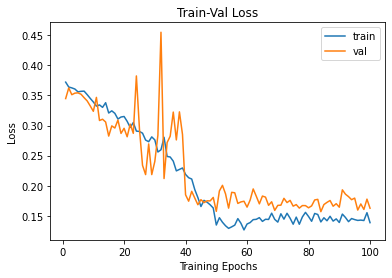

In [ ]:
import matplotlib.pyplot as plt
# Train-Validation progress
num_epochs = 100

# plot loss progress
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_history['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_history['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot accuracy progress
#plt.title('Train-Val Accuracy')
#plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
#plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
#plt.ylabel('Accuracy')
#plt.xlabel('Training Epochs')
#plt.legend()
#plt.show()

In [ ]:
print(sp_frame)

In [ ]:
epoch_validation_loss

0.16270416027773574

In [ ]:
best_loss

0.1569682705212078